# Name : Ameya Chawla
# Student Number : 300281112
# Subject : CSI 5388
# Assignment - 3


# Dynamic Model
1. Imported all the required libraries.

2. Extracted all values by using eval function splitting them using ','.

3. Appended all of the values in t_x,t_y at front.

4. When values are in multiple of 1000 only first 1000 values are in the windows of the dataset as values are being added at front.

5. When the accuracy and recall drops from a certain threshold the model is trained on whole online dataset obtained before.

6. The windows on which retrained is also stored.

7. All calculated accuracies and recall are stored and plotted.

8. Critical Analysis of the result obtained.

In [251]:
from kafka import KafkaConsumer
import pickle
import joblib
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler

In [253]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

static =pickle.load(open('static_model.sav', 'rb')) # Loading the Static Model
dynamic = pickle.load(open('static_model.sav', 'rb'))# Loading the Dynamic Model which is as same as static

accuracy_1 = [] # To store static accuraces
accuracy_2 = [] # To store dynamic accuracies

recall_1 = [] # To store static recall scores
recall_2 = [] # To store dynamic recall scores

t_x = []  # To store all values of x
t_y = []  # To store all values of y 

c = 1 # Count of the windows 

when_retrained = [] # To store all windows values when dynamic model was retrained

for m in consumer:
    
    if c == 1: # Ignoring the first column as it is column names
        
        print('Start of Online data streaming')
        
        #print(eval(m.value).split(','))
        
        c = 2 # Updating the counter so that it doesnt repeat this step
        
        continue
    
        
    temp = eval(m.value) # catching value of whole row
    
    temp_list = temp.split(',') # splitting the row into column values
    
    lent = len(temp_list)  # finding length to segregate last element which is Target Attack
    
    t_x.insert(0,temp_list[0:lent-1]) # putting all values except last one in x
    
    t_y.insert(0,temp_list[lent-1][0]) # only taking first charachter of string as it only the Target attack rest is '\n'. 

    
    if len(t_x) == (c-1)*1000:
        
        c = c+1 #Updating the windows counter 
        
        x = pd.DataFrame(t_x[0:1000]) # Taking first 1000 as values where appened at the start
        
        x = x.drop([0,3,6,9,10,14],axis=1) # Dropping all the features not required as selected in feature selection
      
        tempo = [] #Temp variable to store hash values as hash function doesn't work on whole column and hashing longest_word,sld
        
        for j in x[11]:
            
            tempo.append(hash(j))
        
        x[11] = tempo
        
        tempo = []
        
        for j in x[12]:
            
            tempo.append(hash(j))
        
        x[12] = tempo
        
        
        mm = MinMaxScaler() # Scaling all the values to make them normalize
        x = mm.fit_transform(x)
        
        
        y = pd.DataFrame(t_y[0:1000]) # Only taking first 1000 as we added in front
        y = y.astype('int') # converting to int as it gave error before as it was not automatically converted like x
        
        #print(x.shape,y.shape)   # printing to check if shape is correct
        
        score1 = static.score(x,y) #accuracy for static model
        
        recall = recall_score(y,static.predict(x)) #recall for static model
        
        recall_1.append(recall) # storing recall score for static model
        
        print('\n')
        print('Scores for windows number '+str((c-2))) # c was updated in first if and also at start of loop
        
        print('Static Model Accuracy Score',score1)
        
        print('Static Model Recall Score',recall)
        
        accuracy_1.append(score1) #storing accuracy score for static model
        
        score2 = dynamic.score(x,y) #accuracy score for dynamic model
        
        accuracy_2.append(score2) #storing accuracy score
        
        print('Dynamic Model Accuracy Score',score2)
        
        recall = recall_score(y,dynamic.predict(x))#recall score for synamic model
        
        print('Dynamic Model Recall Score',recall)
        
        recall_2.append(recall)#storing recall score
        
        if(score2 < 0.7695 and recall < 0.95): # The condition is if we get below 5% of values obtained in static dataset we retrain
            
            print('Dynamic Model Retrained in this window')
            
            when_retrained.append(c-2) #appending value as model is retained
            
            tr_x = pd.DataFrame(t_x) # working on whote data obtained till yet
            
            tr_y = pd.DataFrame(t_y) # working on whote data obtained till yet
            
            
            tr_x = tr_x.drop([0,3,6,9,10,14],axis=1) #dropping all the features 
            
            # Hashing all the object columns
            tempo = []
            for j in tr_x[11]:
                tempo.append(hash(j))
                
            tr_x[11] = tempo
            
            tempo = []
            for j in tr_x[12]:
                tempo.append(hash(j))
                
            tr_x[12] = tempo
            
            mm = MinMaxScaler() 
            
            tr_x = mm.fit_transform(tr_x) # Scaling to normalize the data
            
            tr_y = tr_y.astype('int') #converting to int type as it was not automatically converted
            
            dynamic.fit(tr_x,tr_y) #fitting the dynamic model on whole dataset obtained till yet
        
    if(len(t_x)==268064): #stopping condition else it would never stop
        print('\n')
        print('End of Online data streaming')
        break
    
    

Start of Online data streaming


Scores for windows number 1
Static Model Accuracy Score 0.803
Static Model Recall Score 0.9753320683111955
Dynamic Model Accuracy Score 0.803
Dynamic Model Recall Score 0.9753320683111955


Scores for windows number 2
Static Model Accuracy Score 0.789
Static Model Recall Score 0.966789667896679
Dynamic Model Accuracy Score 0.789
Dynamic Model Recall Score 0.966789667896679


Scores for windows number 3
Static Model Accuracy Score 0.666
Static Model Recall Score 0.6022099447513812
Dynamic Model Accuracy Score 0.666
Dynamic Model Recall Score 0.6022099447513812
Dynamic Model Retrained in this window


Scores for windows number 4
Static Model Accuracy Score 0.797
Static Model Recall Score 0.9539007092198581
Dynamic Model Accuracy Score 0.817
Dynamic Model Recall Score 0.9929078014184397


Scores for windows number 5
Static Model Accuracy Score 0.787
Static Model Recall Score 0.9566854990583804
Dynamic Model Accuracy Score 0.793
Dynamic Model Recall Score 0



Scores for windows number 47
Static Model Accuracy Score 0.655
Static Model Recall Score 0.6021314387211367
Dynamic Model Accuracy Score 0.794
Dynamic Model Recall Score 0.9857904085257548


Scores for windows number 48
Static Model Accuracy Score 0.816
Static Model Recall Score 0.9657039711191335
Dynamic Model Accuracy Score 0.83
Dynamic Model Recall Score 0.9891696750902527


Scores for windows number 49
Static Model Accuracy Score 0.674
Static Model Recall Score 0.6029411764705882
Dynamic Model Accuracy Score 0.799
Dynamic Model Recall Score 0.9834558823529411


Scores for windows number 50
Static Model Accuracy Score 0.796
Static Model Recall Score 0.9638989169675091
Dynamic Model Accuracy Score 0.801
Dynamic Model Recall Score 0.9873646209386282


Scores for windows number 51
Static Model Accuracy Score 0.785
Static Model Recall Score 0.9606741573033708
Dynamic Model Accuracy Score 0.799
Dynamic Model Recall Score 0.9850187265917603


Scores for windows number 52
Static Model Ac



Scores for windows number 91
Static Model Accuracy Score 0.595
Static Model Recall Score 0.4720812182741117
Dynamic Model Accuracy Score 0.812
Dynamic Model Recall Score 0.9966159052453468


Scores for windows number 92
Static Model Accuracy Score 0.803
Static Model Recall Score 0.9680284191829485
Dynamic Model Accuracy Score 0.813
Dynamic Model Recall Score 1.0


Scores for windows number 93
Static Model Accuracy Score 0.807
Static Model Recall Score 0.9761029411764706
Dynamic Model Accuracy Score 0.804
Dynamic Model Recall Score 1.0


Scores for windows number 94
Static Model Accuracy Score 0.669
Static Model Recall Score 0.6053639846743295
Dynamic Model Accuracy Score 0.804
Dynamic Model Recall Score 0.9980842911877394


Scores for windows number 95
Static Model Accuracy Score 0.825
Static Model Recall Score 0.9686411149825784
Dynamic Model Accuracy Score 0.83
Dynamic Model Recall Score 1.0


Scores for windows number 96
Static Model Accuracy Score 0.658
Static Model Recall Score 



Scores for windows number 137
Static Model Accuracy Score 0.811
Static Model Recall Score 0.9680851063829787
Dynamic Model Accuracy Score 0.825
Dynamic Model Recall Score 1.0


Scores for windows number 138
Static Model Accuracy Score 0.808
Static Model Recall Score 0.9769911504424779
Dynamic Model Accuracy Score 0.814
Dynamic Model Recall Score 1.0


Scores for windows number 139
Static Model Accuracy Score 0.664
Static Model Recall Score 0.5670840787119857
Dynamic Model Accuracy Score 0.842
Dynamic Model Recall Score 0.9964221824686941


Scores for windows number 140
Static Model Accuracy Score 0.799
Static Model Recall Score 0.9733570159857904
Dynamic Model Accuracy Score 0.806
Dynamic Model Recall Score 0.9946714031971581


Scores for windows number 141
Static Model Accuracy Score 0.67
Static Model Recall Score 0.6178107606679035
Dynamic Model Accuracy Score 0.79
Dynamic Model Recall Score 0.9981447124304267


Scores for windows number 142
Static Model Accuracy Score 0.826
Static



Scores for windows number 182
Static Model Accuracy Score 0.631
Static Model Recall Score 0.5094339622641509
Dynamic Model Accuracy Score 0.803
Dynamic Model Recall Score 0.9981132075471698


Scores for windows number 183
Static Model Accuracy Score 0.809
Static Model Recall Score 0.9782608695652174
Dynamic Model Accuracy Score 0.807
Dynamic Model Recall Score 0.9927536231884058


Scores for windows number 184
Static Model Accuracy Score 0.655
Static Model Recall Score 0.5185185185185185
Dynamic Model Accuracy Score 0.801
Dynamic Model Recall Score 0.9962962962962963


Scores for windows number 185
Static Model Accuracy Score 0.796
Static Model Recall Score 0.968141592920354
Dynamic Model Accuracy Score 0.809
Dynamic Model Recall Score 1.0


Scores for windows number 186
Static Model Accuracy Score 0.646
Static Model Recall Score 0.5850467289719626
Dynamic Model Accuracy Score 0.787
Dynamic Model Recall Score 0.9981308411214953


Scores for windows number 187
Static Model Accuracy Sc



Scores for windows number 226
Static Model Accuracy Score 0.674
Static Model Recall Score 0.6282051282051282
Dynamic Model Accuracy Score 0.8
Dynamic Model Recall Score 0.9981684981684982


Scores for windows number 227
Static Model Accuracy Score 0.831
Static Model Recall Score 0.973109243697479
Dynamic Model Accuracy Score 0.837
Dynamic Model Recall Score 0.9915966386554622


Scores for windows number 228
Static Model Accuracy Score 0.608
Static Model Recall Score 0.4625228519195612
Dynamic Model Accuracy Score 0.802
Dynamic Model Recall Score 0.9872029250457038


Scores for windows number 229
Static Model Accuracy Score 0.619
Static Model Recall Score 0.4785046728971963
Dynamic Model Accuracy Score 0.8
Dynamic Model Recall Score 1.0


Scores for windows number 230
Static Model Accuracy Score 0.795
Static Model Recall Score 0.9714285714285714
Dynamic Model Accuracy Score 0.81
Dynamic Model Recall Score 0.9964285714285714


Scores for windows number 231
Static Model Accuracy Score 0

In [254]:
print(when_retrained) # checking the values when the model was retrained

[3, 82]


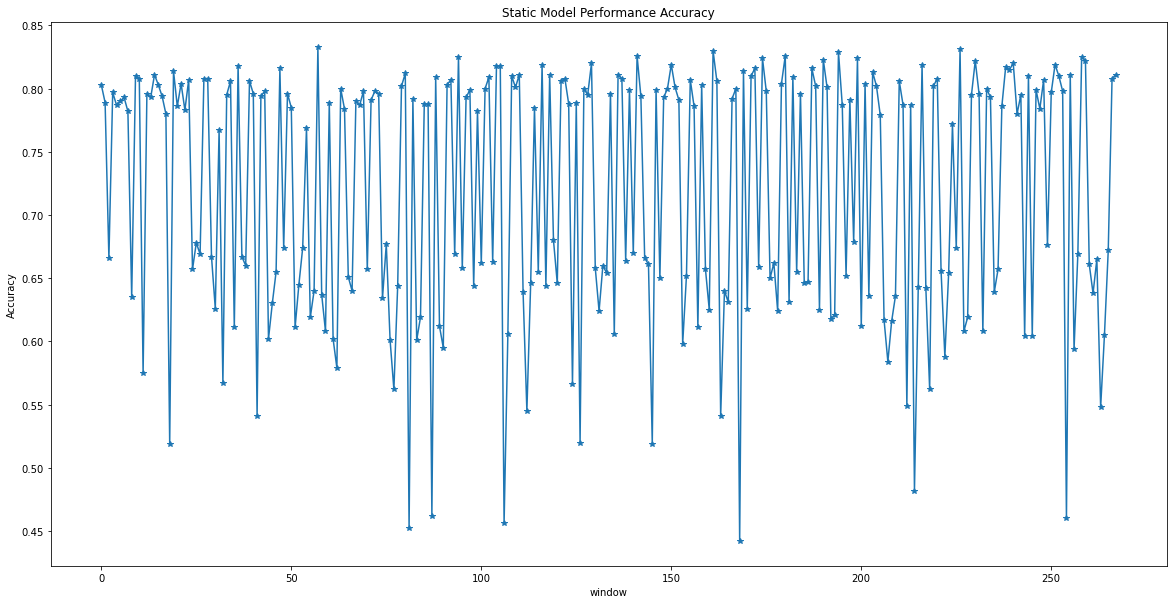

In [255]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.plot(accuracy_1,marker='*')

plt.title('Static Model Performance Accuracy')

plt.xlabel('window')

plt.ylabel('Accuracy')

plt.show()

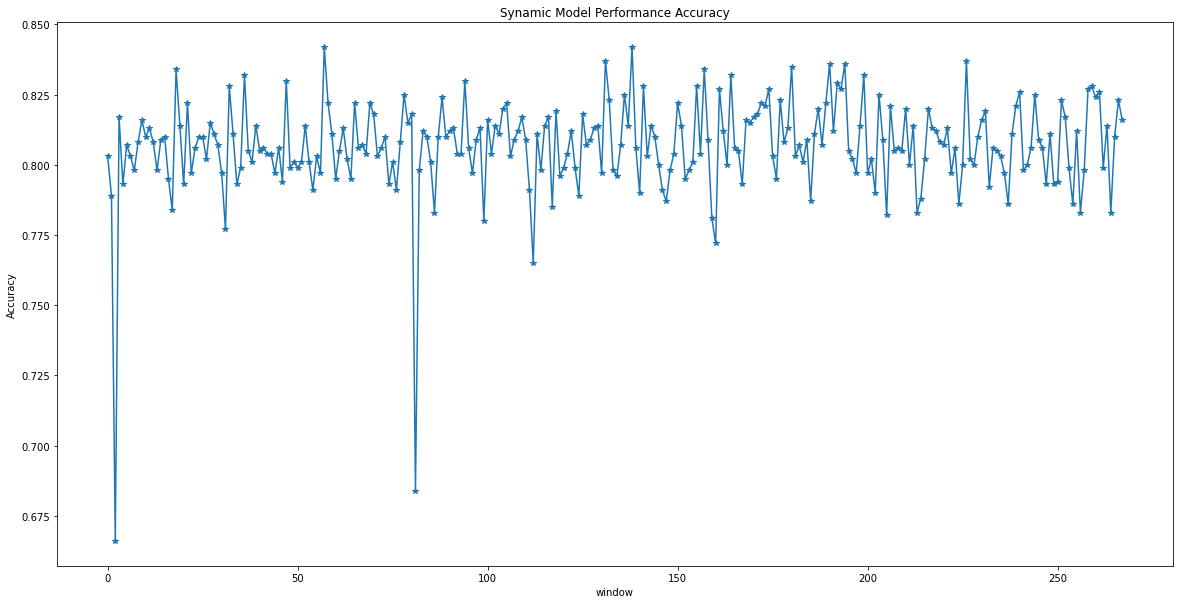

In [256]:
plt.figure(figsize=(20,10))

plt.plot(accuracy_2,marker='*')

plt.title('Synamic Model Performance Accuracy')

plt.xlabel('window')

plt.ylabel('Accuracy')

plt.show()

In [257]:
import numpy as np

In [258]:
print('Variance of Static Model vs Dynamic Model in Accuracy')

print(np.var(accuracy_1),np.var(accuracy_2))


Variance of Static Model vs Dynamic Model in Accuracy
0.009528642501113833 0.00029809595678324715


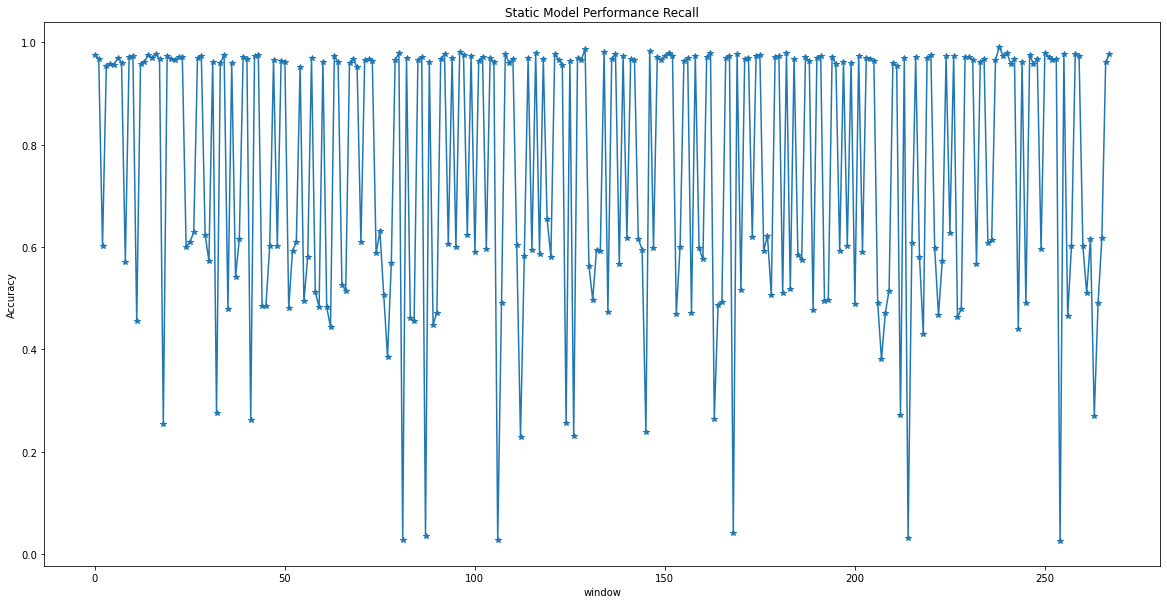

In [259]:
plt.figure(figsize=(20,10))

plt.plot(recall_1,marker='*')

plt.title('Static Model Performance Recall')

plt.xlabel('window')

plt.ylabel('Accuracy')

plt.show()

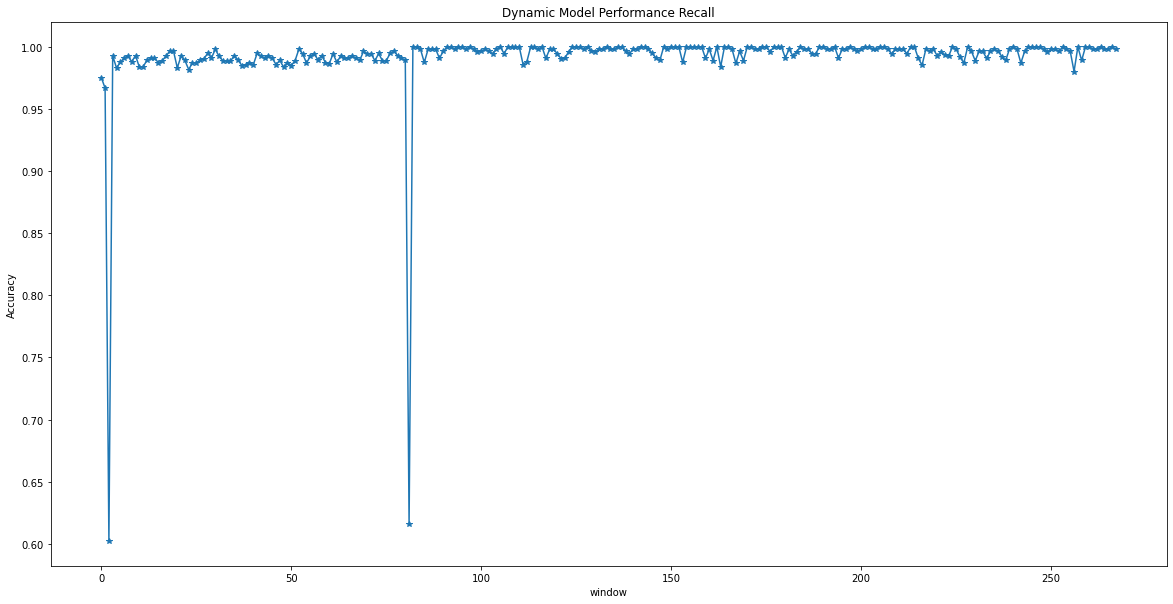

In [260]:
plt.figure(figsize=(20,10))

plt.plot(recall_2,marker='*')

plt.title('Dynamic Model Performance Recall')

plt.xlabel('window')

plt.ylabel('Accuracy')

plt.show()

In [261]:
print('Variance of Static Model vs Dynamic Model in Recall')

print(np.var(recall_1),np.var(recall_2))

Variance of Static Model vs Dynamic Model in Recall
0.06470944358859113 0.001130743724166276


# Analysis of results Obtained

1. Overall dynamic model got higher accuracy and recall score in comparison to static model.


2. There was less variance in scores of dynamic model in comaprison with static model


3. The dynamic model was highly adaptable as it was trained on less dataset as it was trained only on 82000 samples as
it was last trained on 82000 samples in 82th window


4. We are getting high recall score(close to 1) and less accuracy which means model is predicitng almost all positive isntances correctly and some negative isntances incorrectly as we get 0.8 accuracy with recall score of 1 which means the 20% remaining samples are from negative class.


5. Dynamic model is performing better than static as it was only trained on 82000 vs static trained on 3 times more big dataset.


6. Dynamic model is little biased towards positive class as  recall score close to 1.0 and accuracy shows it also has high false positives point 4. But recall score is good which makes it easy for model to detect all the attacks.